In [31]:
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric as pyg
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torch_geometric.loader as pyg_loader
import pytorch_lightning as pl
import torchmetrics
from torch.utils.data import Dataset
from pathlib import Path
from shutil import copyfile
from tqdm import trange, tqdm

import flygym.util.vision as vision
from flygym.util.config import num_ommatidia_per_eye
from flygym.util.data import ommatidia_id_map_path


In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

Build a graph representation of the ommatidia lattice:

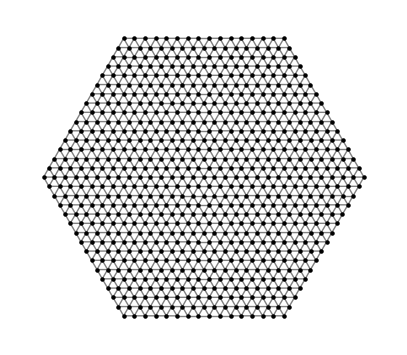

In [3]:
ommatidia_id_map = np.load(ommatidia_id_map_path)
dilation_kernel = np.ones((5, 5), dtype=bool)
edges = set()
node_pos = dict()
for ommatidium_id in range(1, ommatidia_id_map.max() + 1):
    mask_pred = ommatidia_id_map == ommatidium_id
    node_pos[ommatidium_id] = np.mean(np.argwhere(mask_pred), axis=0)
    dilated_mask = ndimage.binary_dilation(mask_pred, dilation_kernel)
    neighbor_ids = np.unique(ommatidia_id_map[dilated_mask])
    for neighbor_id in neighbor_ids:
        if neighbor_id not in [0, ommatidium_id]:
            pair = sorted([ommatidium_id, neighbor_id])
            edges.add(tuple(pair))
graph = nx.from_edgelist(edges)
pg_graph = pyg.utils.from_networkx(graph)

fig, ax = plt.subplots(figsize=(5, 5))
nx.draw(
    graph,
    pos=node_pos,
    node_size=5,
    width=1,
    node_color="black",
    edge_color="gray",
    ax=ax,
)
ax.set_aspect("equal")

Load extracted visual data:

In [4]:
max_num_obstacles = 6
dataset_path = Path("data/visual_samples.pkl")
dataset_df = pd.read_pickle(dataset_path)
dataset_df.sample(5)

,num_obstacles,terrain_name,fly_state_idx,obstacle_state_idx,obstacle_0_x,obstacle_0_y,obstacle_1_x,obstacle_1_y,obstacle_2_x,obstacle_2_y,...,visual_input_right_711,visual_input_right_712,visual_input_right_713,visual_input_right_714,visual_input_right_715,visual_input_right_716,visual_input_right_717,visual_input_right_718,visual_input_right_719,visual_input_right_720
7947,1,gapped,99,47,1.794013,-1.802246,NaN,NaN,NaN,NaN,...,255.0,160.991667,87.570833,83.952381,83.087500,78.147186,86.0000,84.103448,74.128099,97.314655
41902,5,flat,99,2,-8.905346,-6.320438,-0.382286,12.719841,4.419539,9.910502,...,255.0,128.975000,85.504167,98.584416,83.000000,83.000000,83.0000,105.232759,108.000000,108.000000
19945,2,gapped,99,45,-4.879209,13.099716,-2.259218,-0.784109,NaN,NaN,...,255.0,154.479167,86.595833,84.268398,85.091667,82.294372,87.0000,79.465517,50.260331,92.603448
1919,1,flat,99,19,-0.783435,-1.021242,NaN,NaN,NaN,NaN,...,255.0,141.037500,96.175000,95.255411,108.000000,108.000000,108.0000,108.000000,108.000000,89.120690
16540,2,gapped,99,40,-4.424356,-7.399235,2.737771,-4.113179,NaN,NaN,...,255.0,123.645833,74.275000,72.424242,70.512500,81.000000,74.5875,58.668103,81.082645,81.974138


In [5]:
class VisualInputSampleDataset(Dataset):
    def __init__(self, df, noise_std=0.05, distance_threshold=15):
        super().__init__()
        self.df = df
        self.noise_std = noise_std
        self.distance_threshold = distance_threshold

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        etr = self.df.iloc[index]

        # Get input
        intensities = (
            etr[
                [
                    f"visual_input_{side}_{i}"
                    for side in ["left", "right"]
                    for i in range(num_ommatidia_per_eye)
                ]
            ]
            .values.reshape(2, num_ommatidia_per_eye)
            .astype(np.float32)
        )
        intensities /= 255
        intensities += np.random.normal(scale=self.noise_std, size=intensities.shape)
        intensities = np.clip(intensities, 0, 1)
        intensities = torch.tensor(intensities)
        graph_left = pg_graph.clone()
        graph_left.x = intensities[0, :]
        graph_right = pg_graph.clone()
        graph_right.x = intensities[1, :]

        # Get target output
        obstacle_positions = (
            etr[
                [
                    f"obstacle_{i}_{coord}"
                    for i in range(max_num_obstacles)
                    for coord in ["x", "y"]
                ]
            ]
            .values.reshape(-1, 2)
            .astype(np.float32)
        )
        obstacle_positions[np.isnan(obstacle_positions)] = np.inf
        obstacle_distances = np.sqrt((obstacle_positions**2).sum(axis=1))
        obstacle_angle = np.arctan2(obstacle_positions[:, 1], obstacle_positions[:, 0])
        within_fov = (np.abs(obstacle_angle) < np.deg2rad(270 / 2)) & (
            obstacle_distances < self.distance_threshold
        )
        obstacle_positions_in_view = obstacle_positions[within_fov, :]
        if obstacle_positions_in_view.shape[0] == 0:
            target_pos = torch.zeros(2)
            mask = torch.tensor(False)
        else:
            i = np.argmin(obstacle_distances[within_fov])
            target_pos = torch.tensor(obstacle_positions_in_view[i, :])
            mask = torch.tensor(True)

        return {
            "intensity": intensities.float(),
            "graph_left": graph_left,
            "graph_right": graph_right,
            "position": target_pos.float(),
            "object_found": mask,
        }

In [82]:
def visualize_sample(sample):
    sample_intensities = sample["intensity"]
    sample_pos = sample["position"]
    sample_mask = sample["object_found"]
    viz_l = vision.hex_pxls_to_human_readable(
        np.repeat(sample_intensities.numpy()[0, :, np.newaxis], 2, axis=-1) * 255
    )
    viz_r = vision.hex_pxls_to_human_readable(
        np.repeat(sample_intensities.numpy()[1, :, np.newaxis], 2, axis=-1) * 255
    )
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(viz_l, cmap="gray")
    axs[0].axis("off")
    axs[1].imshow(viz_r, cmap="gray")
    axs[1].axis("off")
    print(f"Target position: {sample_pos.numpy()}, mask: {sample_mask.numpy()}")

Dataset size: 50100


/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Target position: [0. 0.], mask: False


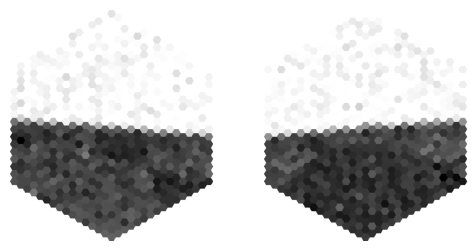

Target position: [5.256069  1.1594081], mask: True


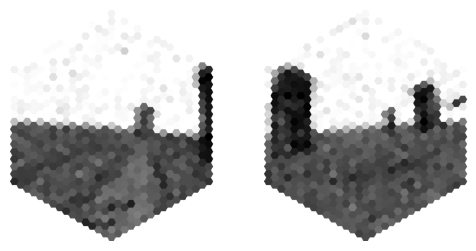

In [7]:
dataset = VisualInputSampleDataset(dataset_df, noise_std=0.05, distance_threshold=15)
print(f"Dataset size: {len(dataset)}")
visualize_sample(dataset[0])
plt.show()
visualize_sample(dataset[40002])
plt.show()

Define a GCN-based modle for feature preprocessing:

In [25]:
from typing import Any


class VisualFeaturePreprocessor(pl.LightningModule):
    def __init__(
        self,
        *,
        in_channels=1,
        conv_hidden_channels=4,
        conv_out_channels=2,
        linear_hidden_channels=16,
        classification_loss_coef=0.01,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.classification_loss_coef = classification_loss_coef
        
        # Define model layers
        self.conv1 = gnn.GCNConv(in_channels, conv_hidden_channels)
        self.conv2 = gnn.GCNConv(conv_hidden_channels, conv_out_channels)
        mlp_in_dim = 2 * conv_out_channels * num_ommatidia_per_eye
        self.linear1 = nn.Linear(mlp_in_dim, linear_hidden_channels)
        self.linear2 = nn.Linear(linear_hidden_channels, linear_hidden_channels)
        self.linear3 = nn.Linear(linear_hidden_channels, 3)
        
        # Define metrics
        self._f1 = torchmetrics.classification.BinaryF1Score()
        self._r2 = torchmetrics.R2Score()

    def forward(self, left_graph, right_graph, batch_size=1):
        conv_features_li = []
        for graph in [left_graph, right_graph]:
            x = self.conv1(graph.x.view(-1, 1), graph.edge_index)
            x = F.tanh(x)
            x = self.conv2(x, graph.edge_index)
            x = F.tanh(x)
            conv_features_li.append(x.view(batch_size, -1))
        conv_features = torch.concat(conv_features_li, axis=1)
        x = self.linear1(conv_features)
        x = F.tanh(x)
        x = self.linear2(x)
        x = F.tanh(x)
        x = self.linear3(x)
        pos_pred = x[:, :2]
        mask_pred = F.sigmoid(x[:, 2])
        return pos_pred, mask_pred
    
    def loss(self, pos_pred, mask_pred, pos_label, mask_label):
        detection_loss = F.binary_cross_entropy(mask_pred, mask_label.float())
        mask = (mask_label == 1) & (mask_pred > 0.5)
        pos_loss = F.mse_loss(pos_pred[mask, :], pos_label[mask, :])
        total_loss = pos_loss + self.classification_loss_coef * detection_loss
        return total_loss, pos_loss, detection_loss
    
    def get_metrics(self, pos_pred, mask_pred, pos_label, mask_label):
        mask_pred_bin = mask_pred > 0.5
        detection_f1 = self._f1(mask_pred_bin.int(), mask_label.int())
        mask = mask_label.bool() & mask_pred_bin
        if mask.sum() < 2:
            pos_r2 = torch.tensor(torch.nan)
        else:
            pos_r2 = self._r2(pos_pred[mask, :].flatten(), pos_label[mask, :].flatten())
        return pos_r2, detection_f1
    
    def training_step(self, batch, batch_idx):
        graphs_left = batch["graph_left"]  # this is a minibatch of graphs
        graphs_right = batch["graph_right"]
        pos_labels = batch["position"]
        mask_labels = batch["object_found"]
        batch_size = mask_labels.size(0)
        
        pos_pred, mask_pred = self.forward(graphs_left, graphs_right, batch_size)
        total_loss, pos_loss, detection = self.loss(
            pos_pred, mask_pred, pos_labels, mask_labels
        )
        
        self.log("train_total_loss", total_loss, batch_size=batch_size)
        self.log("train_pos_loss", pos_loss, batch_size=batch_size)
        self.log("train_detection_loss", detection, batch_size=batch_size)
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        graphs_left = batch["graph_left"]  # this is a minibatch of graphs
        graphs_right = batch["graph_right"]
        pos_labels = batch["position"]
        mask_labels = batch["object_found"]
        batch_size = mask_labels.size(0)
        
        pos_pred, mask_pred = self.forward(graphs_left, graphs_right, batch_size)
        total_loss, pos_loss, detection = self.loss(
            pos_pred, mask_pred, pos_labels, mask_labels
        )
        r2, f1 = self.get_metrics(pos_pred, mask_pred, pos_labels, mask_labels)
        
        self.log("val_total_loss", total_loss, batch_size=batch_size)
        self.log("val_pos_loss", pos_loss, batch_size=batch_size)
        self.log("train_detection_loss", detection, batch_size=batch_size)
        self.log("val_pos_r2", r2, batch_size=batch_size)
        self.log("val_classification_f1", f1, batch_size=batch_size)
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [26]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_loader = pyg_loader.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8)
val_loader = pyg_loader.DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=8)
test_loader = pyg_loader.DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=8)

In [27]:
model_path = "data/models/visual_preprocessor.pt"
retrain = False

if retrain:
    model = VisualFeaturePreprocessor()
    logger = pl.loggers.TensorBoardLogger("logs/", name="visual_preprocessor")
    checkpoint = pl.callbacks.ModelCheckpoint(save_top_k=5, monitor="val_total_loss")
    trainer = pl.Trainer(
        max_epochs=60, logger=logger, log_every_n_steps=15, enable_progress_bar=True
    )
    trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    best_model_path = trainer.checkpoint_callback.best_model_path
    print("Best model:", best_model_path)
    copyfile(best_model_path, model_path)

model = VisualFeaturePreprocessor.load_from_checkpoint(model_path)

In [39]:
model_cpu = model.to("cpu")
pos_pred_all = np.zeros((len(test_ds), 2))
mask_pred_all = np.zeros((len(test_ds)))
pos_label_all = np.zeros((len(test_ds), 2))
mask_label_all = np.zeros((len(test_ds)))

for i, sample in tqdm(enumerate(test_ds), total=len(test_ds)):
    pos_pred, mask_pred = model_cpu(sample["graph_left"], sample["graph_right"])
    pos_pred = pos_pred.detach().numpy()
    mask_pred = mask_pred.detach().numpy()
    pos_label = sample["position"].numpy()
    mask_label = sample["object_found"].numpy()
    pos_pred_all[i, :] = pos_pred
    mask_pred_all[i] = mask_pred
    pos_label_all[i, :] = pos_label
    mask_label_all[i] = mask_label

100%|██████████| 5010/5010 [00:16<00:00, 305.63it/s]


In [58]:
pos_preds_df = pd.DataFrame()
pos_preds_df["x_pred"] = pos_pred_all[:, 0]
pos_preds_df["y_pred"] = pos_pred_all[:, 1]
pos_preds_df["x_label"] = pos_label_all[:, 0]
pos_preds_df["y_label"] = pos_label_all[:, 1]
pos_preds_df["mask_pred"] = mask_pred_all > 0.5
pos_preds_df["mask_pred_prob"] = mask_pred_all
pos_preds_df["mask_label"] = mask_label_all > 0.5
pos_preds_df["common_mask"] = pos_preds_df["mask_pred"] & pos_preds_df["mask_label"]

Test R2 (x): 0.664
Test R2 (y): 0.737
Test F1: 0.989


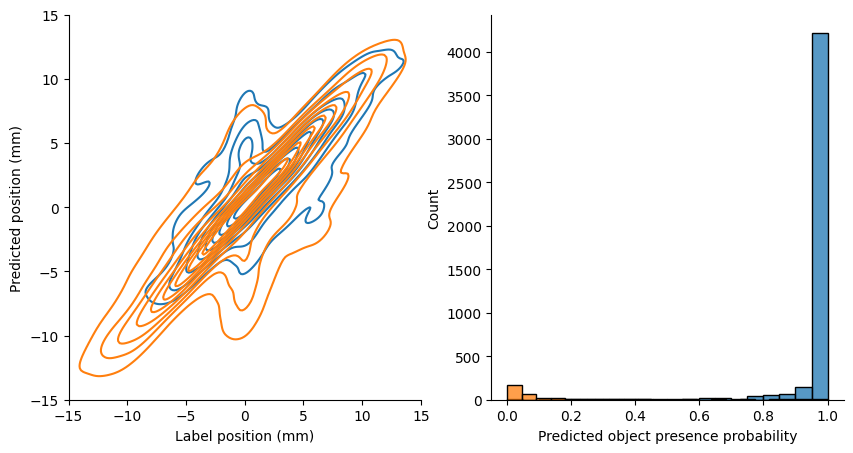

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.kdeplot(x=pos_preds_df["x_label"], y=pos_preds_df["x_pred"], ax=axs[0])
sns.kdeplot(x=pos_preds_df["y_label"], y=pos_preds_df["y_pred"], ax=axs[0])
axs[0].set_xlabel("Label position (mm)")
axs[0].set_ylabel("Predicted position (mm)")
axs[0].set_xlim(-15, 15)
axs[0].set_ylim(-15, 15)

sns.histplot(
    x=pos_preds_df["mask_pred_prob"][pos_preds_df["mask_label"]],
    bins=20,
    binrange=(0, 1),
    ax=axs[1],
)
sns.histplot(
    x=pos_preds_df["mask_pred_prob"][~pos_preds_df["mask_label"]],
    binrange=(0, 1),
    ax=axs[1],
)
axs[1].set_xlabel("Predicted object presence probability")

sns.despine()

test_r2_x = torchmetrics.functional.r2_score(
    torch.tensor(pos_preds_df["x_pred"]), torch.tensor(pos_preds_df["x_label"])
)
test_r2_y = torchmetrics.functional.r2_score(
    torch.tensor(pos_preds_df["y_pred"]), torch.tensor(pos_preds_df["y_label"])
)
test_f1 = torchmetrics.functional.f1_score(
    torch.tensor(pos_preds_df["mask_pred"]),
    torch.tensor(pos_preds_df["mask_label"]),
    task="binary",
)
print(f"Test R2 (x): {test_r2_x:.3f}")
print(f"Test R2 (y): {test_r2_y:.3f}")
print(f"Test F1: {test_f1:.3f}")

In [86]:
def visualize_prediction(sample):
    pos_pred, mask_pred = model_cpu(sample["graph_left"], sample["graph_right"])
    pos_pred = pos_pred.detach().numpy()
    mask_pred = mask_pred.detach().numpy()
    pos_label = sample["position"].numpy()
    mask_label = sample["object_found"].numpy()
    
    visualize_sample(sample)
    # print(f"Object visible: {mask_label > 0.5}")
    print(f"Predicted object presence probability: {mask_pred}")
    # print(f"True position: {pos_label}")
    print(f"Predicted position: {pos_pred}")

Target position: [ 0.9776673 -8.961055 ], mask: True
Predicted object presence probability: [0.9935375]
Predicted position: [[ 1.4413989 -8.362138 ]]


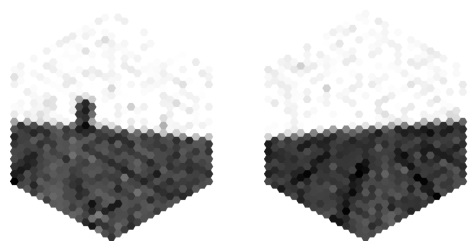

Target position: [-2.9689724  8.950627 ], mask: True
Predicted object presence probability: [0.99850744]
Predicted position: [[-1.8362683  9.09561  ]]


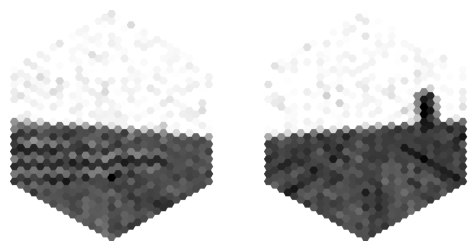

Target position: [ 2.8597853 -5.036399 ], mask: True
Predicted object presence probability: [0.9962353]
Predicted position: [[ 3.162858  -4.9702673]]


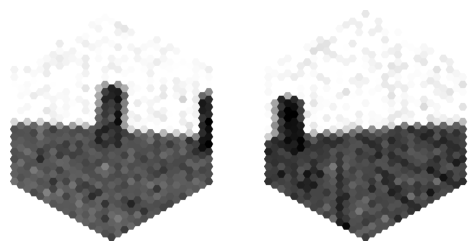

Target position: [-1.8822483  5.2174535], mask: True
Predicted object presence probability: [0.9979693]
Predicted position: [[-2.247539  5.394977]]


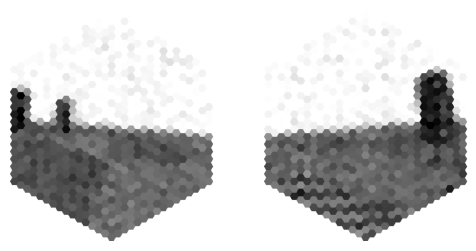

Target position: [ 1.5979774 -1.7244507], mask: True
Predicted object presence probability: [0.99774677]
Predicted position: [[ 1.556769  -1.5567632]]


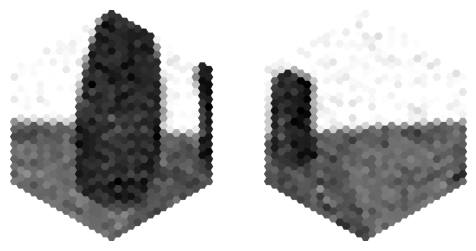

In [88]:
example_idx = np.arange(0, len(test_ds), len(test_ds) // 5)
for idx in example_idx:
    visualize_prediction(test_ds[idx])
    plt.show()